# Number of GREEN$ ePIS registered user

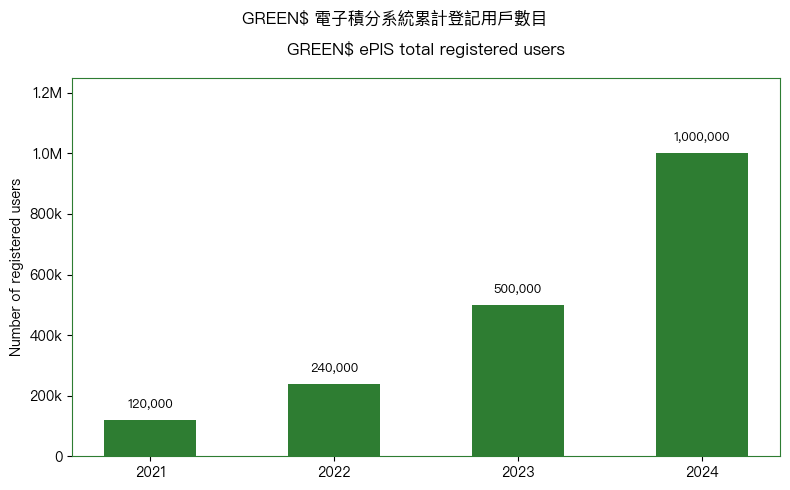

In [3]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
from pathlib import Path

# ---------- load data (specific sheet) ----------
data_path = Path("../General Stats_G@C_clean.xlsx")
sheet_name = "HK MSW Volume and Recycling Rat"
df = pd.read_excel(data_path, sheet_name=sheet_name, engine="openpyxl")

# ---------- helper to find columns by header pattern ----------
def find_col(columns, patterns):
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    for c, norm in cols:
        if any(re.search(p, norm, flags=re.IGNORECASE) for p in patterns):
            return c
    return None

year_patterns  = [r"^year$"]
users_patterns = [r"green\$?\s*epis\s*total\s*registered\s*user"]

year_col  = find_col(df.columns, year_patterns)
users_col = find_col(df.columns, users_patterns)

if year_col is None or users_col is None:
    raise RuntimeError("Could not find Year or GREEN$ ePIS total registered user columns.")

# ---------- clean data & keep only numeric rows ----------
tmp = df[[year_col, users_col]].copy()

# turn into strings, remove commas / spaces
users_str = (
    tmp[users_col]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.strip()
)

# keep only pure numbers like 120000 or 500000 (no 'nan', no blanks)
mask_numeric = users_str.str.fullmatch(r"\d+(\.\d+)?")
users_numeric = users_str[mask_numeric].astype(float)

years_vals = tmp[year_col][mask_numeric].to_list()
users_vals = users_numeric.to_list()

# pretty year labels without ".0"
years_labels = []
for y in years_vals:
    try:
        yf = float(y)
        if abs(yf - round(yf)) < 1e-6:
            years_labels.append(str(int(round(yf))))
        else:
            years_labels.append(str(y))
    except Exception:
        years_labels.append(str(y))

# safety: if nothing valid, stop early
if not users_vals:
    raise RuntimeError("No numeric values found for GREEN$ ePIS total registered user.")

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK",
                  "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = font_name
        break
plt.rcParams["axes.unicode_minus"] = False

# ---------- plot vertical bar chart (green) ----------
fig, ax = plt.subplots(figsize=(8, 5), facecolor="white")
ax.set_facecolor("white")

x = range(len(years_labels))
bar_color = "#2e7d32"  # green

for spine in ax.spines.values():
    spine.set_color(bar_color)

bar_width = 0.5  # leaves some space between bars
bars = ax.bar(x, users_vals, width=bar_width, color=bar_color)

max_val = max(users_vals)
ax.set_ylim(0, max_val * 1.25)

# format y-axis as 200k, 400k, ..., 1.2M
def users_formatter(value, pos):
    if value >= 1_000_000:
        return f"{value/1_000_000:.1f}M"
    elif value >= 1_000:
        return f"{int(value/1_000)}k"
    elif value == 0:
        return "0"
    else:
        return f"{value/1_000:.1f}k"

ax.yaxis.set_major_formatter(FuncFormatter(users_formatter))

# labels on top of bars (full numbers, with commas)
for xi, v in zip(x, users_vals):
    ax.text(
        xi,
        v + max_val * 0.03,
        f"{int(v):,}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

ax.set_xticks(list(x))
ax.set_xticklabels(years_labels, rotation=0, ha="center")

ax.set_ylabel("Number of registered users")

title_cn = "GREEN$ 電子積分系統累計登記用戶數目"
title_en = "GREEN$ ePIS total registered users"
fig.suptitle(title_cn, y=0.97)
ax.set_title(title_en, pad=16)

plt.tight_layout()
plt.show()
